In [67]:
import yfinance as yf
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


In [68]:
tickerSymbol = 'AAPL'
data = yf.Ticker(tickerSymbol)
prices = data.history(start='2021-01-01', end='2023-05-23').Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

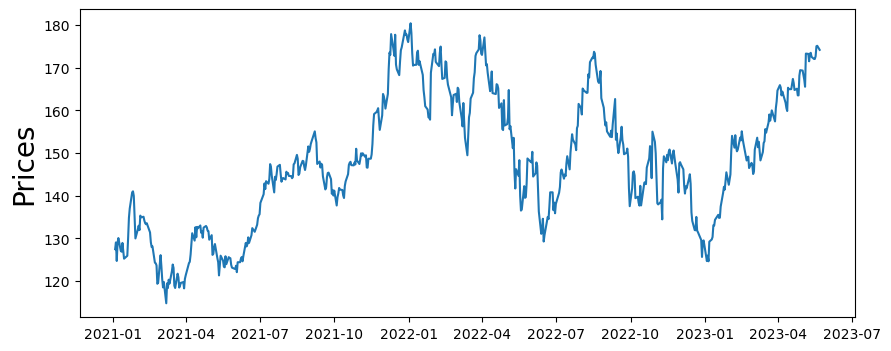

In [3]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

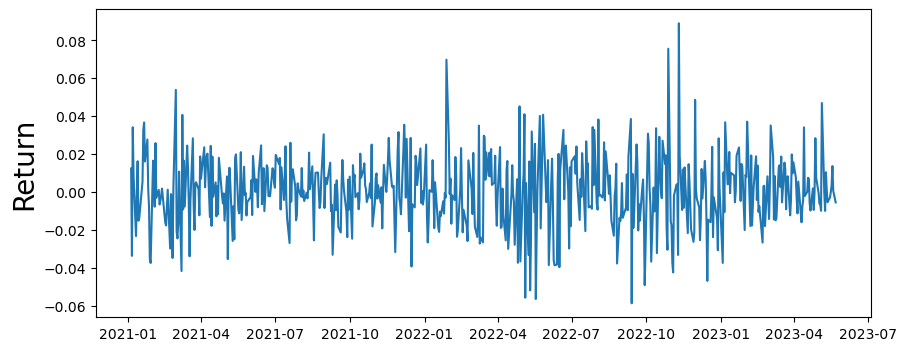

In [4]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

In [5]:
result = adfuller(returns)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -18.770705
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


Haciendo test vemos que se rechaza la hipotesis de no estacionalidad

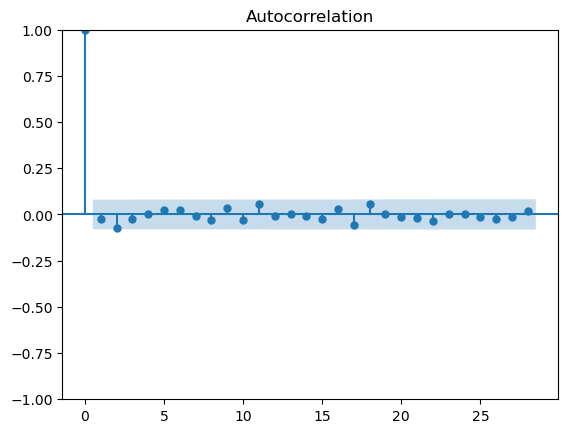

In [7]:
plot_acf(returns)

plt.show()

C:\Users\fridm\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


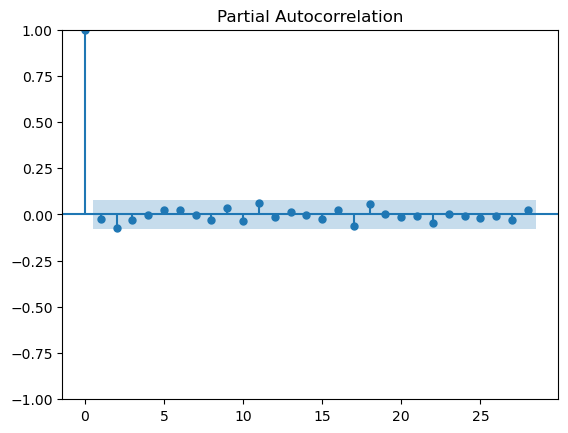

In [8]:
plot_pacf(returns)
plt.show()

En un principio esto nos dice el orden de auto correlacion y el orden de autocorrelacion parcial es bajo y por lo tanto solo debria usarse la primera si es que alguna

In [24]:
returnsTrain = returns[0:350]
returnsTest = returns[350:]

In [25]:
returnsTest

Date
2022-05-25 00:00:00-04:00    0.001140
2022-05-26 00:00:00-04:00    0.023200
2022-05-27 00:00:00-04:00    0.040757
2022-05-31 00:00:00-04:00   -0.005346
2022-06-01 00:00:00-04:00   -0.000873
                               ...   
2023-05-16 00:00:00-04:00    0.000000
2023-05-17 00:00:00-04:00    0.003603
2023-05-18 00:00:00-04:00    0.013666
2023-05-19 00:00:00-04:00    0.000628
2023-05-22 00:00:00-04:00   -0.005481
Name: Close, Length: 249, dtype: float64

In [ ]:
MODELO:

C:\Users\fridm\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, phi]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
C:\Users\fridm\AppData\Local\Temp\ipykernel_3372\2271593262.py:13: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fridm\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


<Figure size 700x700 with 0 Axes>

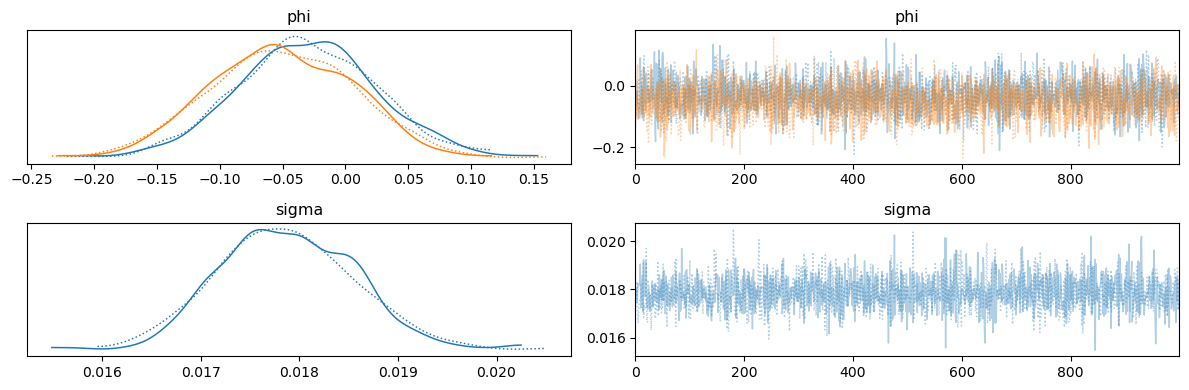

In [26]:
with pm.Model() as bayes_model:
    #priors
    phi = pm.Normal("phi", mu=0, sigma=20, shape=2)
    sigma = pm.Exponential("sigma", lam=1/100)

    #Likelihood
    likelihood = pm.AR("x", phi, sigma, observed=returnsTrain)

    #posterior
    trace = pm.sample(1000, cores=2)
    
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout()

In [ ]:
# Se pueden analizar los coeficientes de la regresion
phi1_vals = trace.get_values('phi')[:,0]
phi2_vals = trace.get_values('phi')[:,1]
sigma_vals = trace.get_values('sigma')

In [30]:
model = sm.tsa.arima.ARIMA(returnsTrain, order=(2,0,0)).fit()
model.summary()

C:\Users\fridm\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fridm\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fridm\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  350
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 913.347
Date:                Wed, 24 May 2023   AIC                          -1818.693
Time:                        17:58:00   BIC                          -1803.262
Sample:                             0   HQIC                         -1812.551
                                - 350                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.456      0.648      -0.001       0.002
ar.L1         -0.0294      0.048     -0.614      0.539      -0.123       0.065
ar.L2         -0.0504      0.050     -1.004      0.315      -0.149       0.048
sigma2         0.0003    2.1e-05     15.109      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 7.32
Prob(Q):                              0.89   Prob(JB):                         0.03
Heteroskedasticity (H):               1.53   Skew:                            -0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
forcastNew = model.get_prediction(0,350 + len(returnsTest))
forcastNew.conf_int([0.05])[350: 350 + len(returnsTest)]

C:\Users\fridm\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,lower Close,upper Close
350,-0.035888,0.033871
351,-0.033451,0.036338
352,-0.034483,0.035392
353,-0.034578,0.035298
354,-0.034525,0.035350
...,...,...
594,-0.034525,0.035351
595,-0.034525,0.035351
596,-0.034525,0.035351
597,-0.034525,0.035351


C:\Users\fridm\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


InvalidIndexError: (slice(None, None, None), 0)

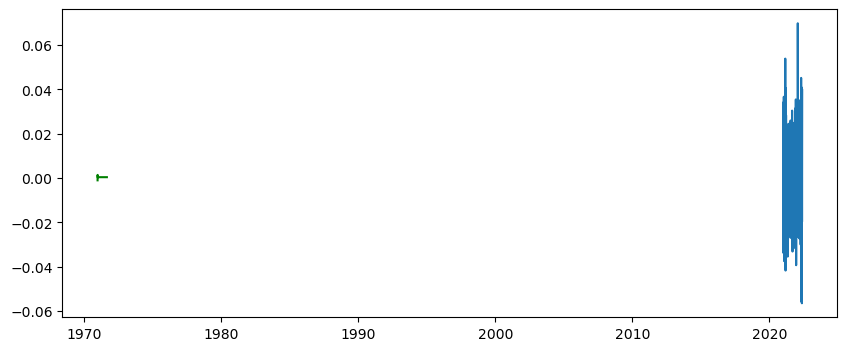

In [66]:
plt.figure(figsize=(10,4))
plt.plot(returnsTrain)
forecast = model.forecast(249)

plt.plot(range(len(returnsTrain), len(returnsTrain) + 249), forecast, color='g')
plt.fill_between(range(len(returnsTrain), len(returnsTrain) + 249), forcastNew.conf_int([0.05])[350:350+249][:,0], forcastNew.conf_int([0.05])[350:250+249][:,1], color='g', alpha=0.25)